# Guide to ViMMS (03/10/2023)

ViMMS (Virtual Metabolomics Mass Spectrometer) is a Python-based software for the simulation of **liquid chromatography mass spectrometry** (LC-MS/MS) data acquisition in metabolomics studies. Simulations through ViMMS are a low-cost way to optimise acquisition strategy parameters before running a real experiment, or can be used to quickly prototype new [acquisition](https://pubs.acs.org/doi/full/10.1021/acs.analchem.0c03895) [strategies](https://academic.oup.com/bioinformatics/article/39/7/btad406/7207825) in Python. With the appropriate bridging code for a given instrument model, ViMMS can also be used to run an acquisition strategy on a real LC-MS/MS setup using the same high-level Python code.

### Why Metabolomics?

Metabolomics is a rapidly-growing area of research concerned with profiling the concentrations of biomolecules associated with an organism's metabolism. This biochemistry is very closely tied to the biological functions of the organism and therefore is richly informative about them. To illustrate this effect, an interesting and well-publicised motivating example in human studies is the case of Joy Milne, [the woman who can smell Parkinson's disease](https://www.npr.org/sections/health-shots/2020/03/23/820274501/her-incredible-sense-of-smell-is-helping-scientists-find-new-ways-to-diagnose-di). Some [recent research](https://www.nature.com/articles/s41467-021-21669-4) aims to identify metabolomic biomarkers which could explain her ability to smell the disease. Another example is that of [studies](https://www.sciencedirect.com/science/article/pii/S030881462031709X) [investigating](https://www.sciencedirect.com/science/article/pii/S0924224418303741) ["food fraud"](https://pubs.acs.org/doi/10.1021/acs.jafc.1c07153), where components of food are replaced with lower value substitutes, similarly to the well-known example of [horse meat in burgers](https://en.wikipedia.org/wiki/2013_horse_meat_scandal). These studies examine the usefulness of using metabolomic profiling to, for example, determine the providence of beef or honey. 

ViMMS is aiming to improve the usefulness of the LC-MS/MS data collected by an acquisition strategy - namely the number and quality of fragmentation spectra - and so will be able to aid works like these.

### Basics of LC-MS/MS

(An alternative guide covering similar material but more concerned with the instrumentation and chemistry can be found [here](https://www.agilent.com/cs/library/support/documents/a05296.pdf).)

To profile an organism's metabolome, chemists commonly use LC-MS/MS. Mass spectrometers ionise molecules, imbuing them with electrical charge, and then very accurately separate them by the ratio of their **mass-to-charge** (m/z). These ions can then be measured by a detector. This gives us an **intensity** of signal for each mass-to-charge value detected, from which we may be able to extrapolate the number of ions of that m/z and in theory its chemical concentration. Then if the charge of an ion is known, we can identify its molecular mass, which may be used to identify it. Direct injection of a sample into a mass spectrometer produces a mass spectrum which should look something like this:

2023-10-03 17:39:18.928 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 677 scans


scan rt: 383.1999999999955


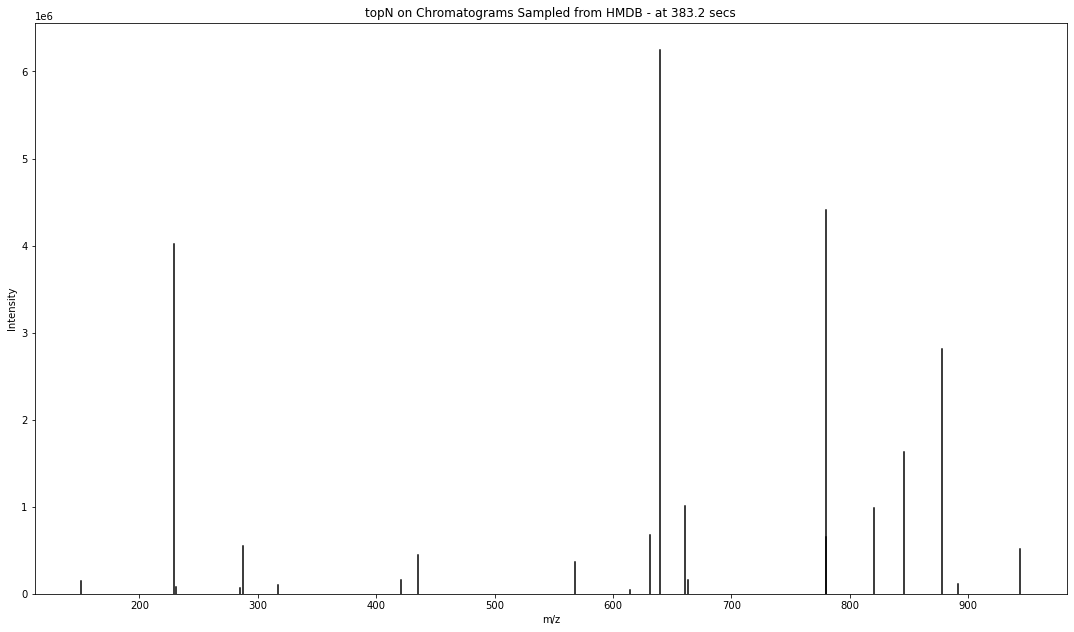

In [1]:
# Plot a mass spectrum

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from vimms.Common import path_or_mzml

def plot_mzml_2d(scan, title=None):
    fig, ax = plt.subplots(1, 1)
    
    for mz, intensity in scan.peaks:
        ax.plot(np.array([mz, mz]), np.array([0, intensity]), color="black")
    
    ax.set(
        title=title,
        xlabel="m/z", 
        ylabel="Intensity",
        ylim=[0, None]
    )
    fig.set_size_inches(18.5, 10.5)
    return fig

mzml_path = os.path.join("tests", "fixtures", f"demoN0.mzML") # This file was previously generated with some synthetic chemicals with their chromatograms sampled from HMDB
mzml = path_or_mzml(mzml_path)
scan = max((s for s in mzml.scans), key=lambda s: len(s.peaks))
print(f"scan rt: {scan.rt_in_seconds}")
title = f"topN on Chromatograms Sampled from HMDB - at {round(scan.rt_in_seconds, 2)} secs"
fig = plot_mzml_2d(scan, title=title)

However, what if two different molecules have the same mass-to-charge ratio? For example, suppose you have two molecules which have the same chemical formula but a different structure --- structural isomers --- and they have the same charge. This creates two problems. Firstly, any of the intensity measurements for a given m/z could be caused by two (or more) species of ion i.e. any of the bars on the picture above might be two or more separate measurements added together. In this case we would be unable to separate the total measurement into contributions for each species. Secondly, this also implies that the molecular mass may be insufficient to identify a given molecular species. 

To combat the first problem we can use **liquid chromatography** (LC). LC is a separation technique which retains different molecules for different lengths of time in the chromatographic column before generating them into the MS. As they are released we continue to measure them via mass spectrometry, causing us to generate a time-series of mass spectra. That is, a third **retention-time** (RT) dimension is added to our previously two-dimensional (m/z, intensity) mass spectra. An LC setup appropriately designed for this use should separate molecules in a way that is independent of their mass, and thus different ion species should appear in different mass spectra at different retention times, allowing us to measure them separately even if they would otherwise have the same m/z. Mass spectrometry can also be paired with gas chromatography or other separation techniques, but liquid chromatography is often used for metabolomics because many kinds of biomolecule are not amenable to analysis via other techniques. 

As molecules gradually appear from the chromatographic column, their distribution on intensity over retention time typically follows a Gaussian-like shape. These **chromatographic peaks** can often be used to separate real signal from noise in data. LC-MS data should therefore look something like this (note the Gaussian-like shapes as we start taking more scans):

2023-10-03 17:39:19.257 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 677 scans


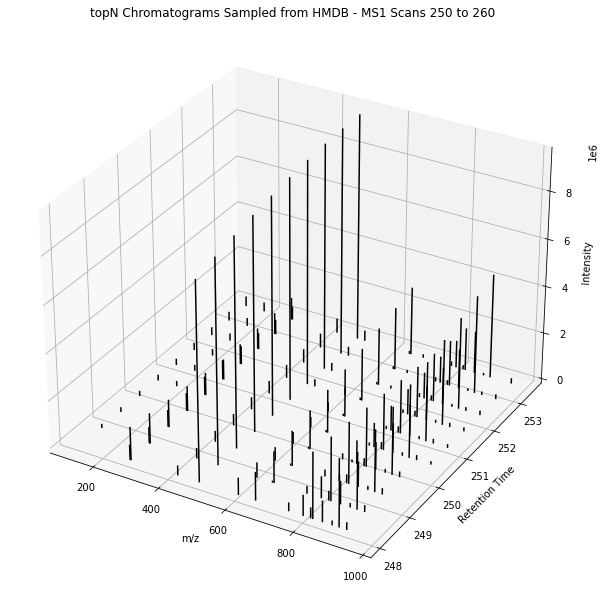

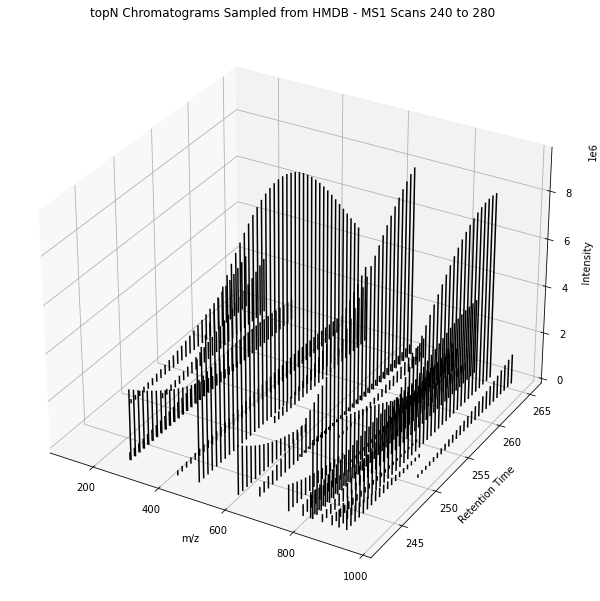

In [2]:
# Plot 3D chromatograms

import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_mzml_3d(ax, mzml, scan_lower, scan_upper, title=""):
    for scan in mzml.scans[scan_lower:scan_upper]:
        rt = scan.rt_in_seconds
        for mz, intensity in scan.peaks:
            ax.plot(np.array([mz, mz]), np.array([rt, rt]), np.array([0, intensity]), color="black")

        ax.set(
            title=title,
            ylabel="Retention Time",
            xlabel="m/z",
            zlabel="Intensity",
            zlim=[0, None],
        )

mzml_path = os.path.join("tests", "fixtures", f"demoN0.mzML") # This file was previously generated with some synthetic chemicals with their chromatograms sampled from HMDB
mzml = path_or_mzml(mzml_path)

scan_ranges = [(250, 260), (240, 280)]
for scan_lower, scan_upper in scan_ranges:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_mzml_3d(
        ax,
        mzml, 
        scan_lower, 
        scan_upper, 
        title=f"topN Chromatograms Sampled from HMDB - MS1 Scans {scan_lower} to {scan_upper}"
    )

    ax.autoscale()
    fig.set_size_inches(18.5, 10.5)

To combat the second problem we can use **tandem mass spectrometry** (MS/MS). In tandem mass spectrometry we pair two mass analysers together, allowing for two stages of separation by mass-to-charge prior to measurement. This allows us to isolate ions of a small mass-to-charge range, fragment the isolated ions, and then measure (m/z, intensity) pairs for the fragments via mass spectrometry. When fragmenting an ion it may be common for it to break on characteristic bonds. For example, if it was common to break on a given bond, you might see readings at two m/z values which add together to approximately the same m/z as the precursor ion. Therefore the distribution of fragments forms a sort of "structural fingerprint" which can be used to identify the species of the ion. Later one may compare a collected fragmentation spectrum to databases via e.g. treating fragmentation spectra as vectors and using the cosine score to compare the distribution of fragments. Fragmentation spectra are of the same format as the 2D mass spectrum above.

### Acquisition Strategies

In a full LC-MS/MS system we therefore have decisions to make as we process a sample over time. Whenever the system is idle we must choose between performing an MS1 scan or an MS2 scan. An **MS1 scan** measures all ions currently eluting from the chromatographic column. An **MS2 scan** isolates ions of a given m/z range, fragments them, and measures the fragments. If we choose to perform an MS2 scan we must also choose the m/z range which we want to isolate and fragment. Generally speaking we want to obtain rich MS1 measurements, but also fragment as many chromatographic peaks as possible at the highest intensity i.e. when the most precursor ions are available for fragmentation. An inappropriately-timed task may have an opportunity cost for another potential task. To manage this complex scheduling problem we need an acquisition strategy.

## Structure of ViMMS

One of the goals of ViMMS is to aid in the design and testing of new fragmentation strategies, and the project has been structured with this aim in mind. To perform a simulated experiment with ViMMS you need three things: a controller which implementing a fragmentation strategy, a set of chemical objects and a virtual mass spectrometer. These can be freely switched out to allow, for example, testing multiple fragmentation strategies, or testing the same fragmentation strategy on multiple samples. Additionally, when utilising real instrument control, the mass spectrometer object is exchanged with a connection to the real instrument, and the chemical objects are replaced by signal coming off of that instrument.

In [3]:
# TODO: illustrative graphic?

In [4]:
import os
import sys

user_vimms = os.path.join( # Put your path to your install of ViMMS here!
    "C:\\",
    "Users",
    "mcbrider5002",
    "Desktop",
    "Workspace",
    "phd",
    "peak_picking",
    "vimms"
)

sys.path.append(user_vimms) # Add ViMMS to your Python path, so your Python install knows where to look when this notebook does an import...

## Chemical Creation

ViMMS simulations can obtain chemical objects from two sources. Firstly, we can generate purely synthetic chemicals by some form of sampling on e.g. a database or statistical distribution. Secondly, we can re-simulate an existing experiment by using a seed .mzML to generate chemical objects. In this case we perform Region-of-Interest (RoI) construction over the whole file to group points that are close in m/z and which appear in contiguous scans. Each of these RoIs then becomes a `Chemical` object. Generally it is preferable to use a fullscan .mzML (MS1 scans only) as the seed .mzML as the richer MS1 information allows better `Chemical` objects to be constructed. How MS2 spectra are assigned to synthetic or re-simulated `Chemical` objects depends on the intended application - for example (and by default) we might them sample from a relatively arbitrary distribution if we don't care about their contents or lack sufficient knowledge about the sample to generate accurate spectra.

Synthetic chemicals are often a lot simpler, and can be tightly controlled to test specific hypotheses. To generate a set of synthetic chemicals we can use the `ChemicalMixtureCreator` class. This class has a lot of behaviours that can be configured by passing different child objects, including:

- Chemical formula generation
- RT/intensity generation for formulas
- Chromatograms for formulas
- MS2 spectra for formulas

Below we give an example of how we can generate synthetic chemicals both by sampling their masses both uniformly and from the Human Metabolome Database (HMDB) but a more detailed treatment of the features available can be found in demo notebooks on the GitHub repository.

In [5]:
# Generate some synthetic chemicals

from vimms.Common import load_obj
from vimms.Chemicals import ChemicalMixtureCreator
from vimms.ChemicalSamplers import DatabaseFormulaSampler, UniformMZFormulaSampler, UniformRTAndIntensitySampler

u_rt = UniformRTAndIntensitySampler(min_rt=100, max_rt=500) # Uniform RT and intensity sampling for both

# Uniformly sample m/z
u_mz = UniformMZFormulaSampler(min_mz=100, max_mz=500)
cm = ChemicalMixtureCreator(u_mz, rt_and_intensity_sampler=u_rt) #Note: defaults are being used to sample chromatograms and MS2 spectra
u_chems = cm.sample(5000, 2)

# Sample m/z from HMDB
hmdb = load_obj(os.path.join(user_vimms, "tests", "fixtures", "hmdb_compounds.p")) # Pickled HMDB stuff lives in the ViMMS repo
df = DatabaseFormulaSampler(hmdb, min_mz=100, max_mz=1000)
cm = ChemicalMixtureCreator(df, rt_and_intensity_sampler=u_rt)
hmdb_chems = cm.sample(5000, 2)

2023-10-03 17:39:23.923 | DEBUG    | vimms.Chemicals:sample:664 - Sampled rt and intensity values and chromatograms
2023-10-03 17:39:28.231 | DEBUG    | vimms.ChemicalSamplers:sample:84 - 73822 unique formulas in filtered database
2023-10-03 17:39:28.233 | DEBUG    | vimms.ChemicalSamplers:sample:90 - Sampled formulas
2023-10-03 17:39:30.800 | DEBUG    | vimms.Chemicals:sample:664 - Sampled rt and intensity values and chromatograms


Re-simulations contain things that you don't necessarily have understanding or control over, but are naturally a lot more realistic. You can construct a set of re-simulated chemicals simply by invoking `ChemicalMixtureFromMZML` on the filepath to the seed .mzML. This object also allows you to specify the parameters for RoI construction when building chemicals or the distribution to sample MS2 spectra from.

In [6]:
# Generate chemicals from an .mzML

import os

from vimms.Roi import RoiBuilderParams
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.ChemicalSamplers import FixedMS2Sampler

beer_fullscan = os.path.join("tests", "fixtures", "fullscan_beer1_0.mzML") # Seed

rp = RoiBuilderParams(
    min_roi_intensity=0, # Ignore all points below this threshold
    at_least_one_point_above=0, # Ignore all RoIs without a point above this threshold
    min_roi_length=2 # Ignore all RoIs below this length
)

cm = ChemicalMixtureFromMZML(
    beer_fullscan, 
    roi_params=rp, 
    ms2_sampler=FixedMS2Sampler() # Generate fragments that are just fixed steps away from parent m/z - efficient if we don't care at all about the contents
)

beer_chems = cm.sample(
    None, # Cap on number of chemicals to use... Take all RoIs in this case
    2 # Maximum MS level... Assign MS2 spectra to chemicals
)

2023-10-03 17:42:21.134 | DEBUG    | vimms.Chemicals:_extract_rois:834 - Extracted 292135 good ROIs from tests\fixtures\fullscan_beer1_0.mzML


## Running Simulations

Now we have a simulated sample to run on - let's run a simulation. We'll compare the ViMMS implementation of the TopN controller that comes standard with every instrument to the multi-sample Intensity Non-Overlap controller we introduced in one of our [publications](https://academic.oup.com/bioinformatics/article/39/7/btad406/7207825?login=false).

To run an injection in a simulated experiment, first we pass our `Chemical` objects to an `IndependentMassSpectrometer` object, and initialise one controller object of the appropriate type to be run on it (e.g. `TopNController`). We pass these to a simulated `Environment` object, and then call run on it. We perform this process once per each injection - if the controller is a multi-sample controller like Intensity Non-Overlap, then it contains a shared state object (in this case a `BoxGeometry` for managing exclusion boxes) which is passed around the controllers in sequence.

In [7]:
# Some shared stuff to make it easier to run experiments

import os

from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Environment import Environment

out_dir = os.path.join("tests", "results")

min_rt, max_rt = 0, 1440 # Interval to be simulated
scan_duration_dict = {1: 0.59, 2: 0.19} # For reproducibility, fix each scan's length to average lengths on our instrument

def run_controller(controller, dataset, out_dir, out_file):
    '''Small helper to reduce boilerplate...'''
    mass_spec = IndependentMassSpectrometer( # Instantiate a different simulated MS for every run
        POSITIVE, # Mode to run the instrument in 
        dataset,
        scan_duration=scan_duration_dict
    )
    
    env = Environment(
        mass_spec, 
        controller, 
        min_rt, 
        max_rt, 
        progress_bar=True,
        out_dir=out_dir,
        out_file=out_file # Write to an .mzML
    ) # Environment object glues together MS and controller
    
    env.run()
    return env

C:\Users\mcbrider5002\anaconda3\lib\site-packages\psims\mzmlb\writer.py:15: UserWarning:

hdf5plugin is missing! Only the slower GZIP compression scheme will be available! Please install hdf5plugin to be able to use Blosc.



First let's run the experiment on our uniformly-sampled synthetic chemicals (sampling lots of chemicals from HMDB can behave badly by sampling the same values repeatedly):

In [8]:
# Run an experiment on synthetic data

from vimms.Common import POSITIVE
from vimms.Roi import RoiBuilderParams
from vimms.Box import BoxGrid
from vimms.BoxManager import BoxSplitter, BoxManager
from vimms.Controller import TopNController
from vimms.Controller.box import IntensityNonOverlapController

u_chem_list = [u_chems] * 3 # n injections of same sample
scan_duration_dict = {1: 0.59, 2: 0.19} # For reproducibility, fix each scan's length to average lengths on our instrument

rp = RoiBuilderParams( # Parameters for building RoIs during a run
    min_roi_intensity=0,
    min_roi_length=3,
)

geom = BoxManager( # State object to carry over info between samples in Intensity Non-Overlap
    box_geometry = BoxGrid(), # Data structure to searches boxes quickly
    box_splitter = BoxSplitter(split=True) # Splitting boxes is necessary for INO
)

# Store to evaluate later
topN_envs = []
ino_envs = []

for i, dataset in enumerate(u_chem_list):
    topN_controller = TopNController(
        ionisation_mode=POSITIVE,
        isolation_width=1.0,
        N=10,  
        mz_tol=10, # In parts per million
        rt_tol=60, # In seconds
        min_ms1_intensity=5000
        # Lots of optional parameters omitted!
    )
    topN_envs.append(
        run_controller(topN_controller, dataset, out_dir, f"hmdb_topN_{i}.mzML")
    )
    
    ino_controller = IntensityNonOverlapController(
        ionisation_mode=POSITIVE,
        isolation_width=1.0,
        N=10,  
        mz_tol=10, # In parts per million
        rt_tol=60, # In seconds
        min_ms1_intensity=5000,
        roi_params=rp,
        grid=geom,
        min_roi_length_for_fragmentation=0
        # Lots of optional parameters omitted!
    )
    ino_envs.append(
        run_controller(ino_controller, dataset, out_dir, f"hmdb_intensity_non_overlap_{i}.mzML")
    )

2023-10-03 17:42:35.993 | DEBUG    | vimms.Chemicals:__init__:477 - FastMemoryChems initialised


  0%|          | 0/1440 [00:00<?, ?it/s]

2023-10-03 17:42:36.016 | DEBUG    | vimms.Environment:handle_acquisition_open:125 - Acquisition open
2023-10-03 17:42:36.147 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 100.300000 Minimum intensity threshold 5000.000000 reached at 2457.016441, 3
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2023-10-03 17:42:42.656 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 539.700000 Minimum intensity threshold 5000.000000 reached at 4947.510544, 0
2023-10-03 17:42:42.660 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 540.290000 Minimum intensity threshold 5000.000000 reached at 4802.180799, 0
2023-10-03 17:42:42.663 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 540.880000

  0%|          | 0/1440 [00:00<?, ?it/s]

2023-10-03 17:42:48.849 | DEBUG    | vimms.Environment:handle_acquisition_open:125 - Acquisition open
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2023-10-03 17:43:05.262 | DEBUG    | vimms.Environment:write_mzML:247 - Created mzML file tests\results\hmdb_intensity_non_overlap_0.mzML
2023-10-03 17:43:05.263 | DEBUG    | vimms.Chemicals:__init__:477 - FastMemoryChems initialised


  0%|          | 0/1440 [00:00<?, ?it/s]

2023-10-03 17:43:05.284 | DEBUG    | vimms.Environment:handle_acquisition_open:125 - Acquisition open
2023-10-03 17:43:05.418 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 100.300000 Minimum intensity threshold 5000.000000 reached at 2457.016441, 3
2023-10-03 17:43:13.852 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 539.700000 Minimum intensity threshold 5000.000000 reached at 4947.510544, 0
2023-10-03 17:43:13.856 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 540.290000 Minimum intensity threshold 5000.000000 reached at 4802.180799, 0
2023-10-03 17:43:13.860 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 540.880000 Minimum intensity threshold 5000.000000 reached at 4672.081337, 0
2023-10-03 17:43:13.864 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 541.470000 Minimum intensity threshold 5000.000000 reached at 4967.283184, 0
2023-10-03 17:43:13.867 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 542.060000 Mini

  0%|          | 0/1440 [00:00<?, ?it/s]

2023-10-03 17:43:18.624 | DEBUG    | vimms.Environment:handle_acquisition_open:125 - Acquisition open
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2023-10-03 17:43:35.098 | DEBUG    | vimms.Environment:write_mzML:247 - Created mzML file tests\results\hmdb_intensity_non_overlap_1.mzML
2023-10-03 17:43:35.099 | DEBUG    | vimms.Chemicals:__init__:477 - FastMemoryChems initialised


  0%|          | 0/1440 [00:00<?, ?it/s]

2023-10-03 17:43:35.122 | DEBUG    | vimms.Environment:handle_acquisition_open:125 - Acquisition open
2023-10-03 17:43:35.251 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 100.300000 Minimum intensity threshold 5000.000000 reached at 2457.016441, 3
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2023-10-03 17:43:41.623 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 539.700000 Minimum intensity threshold 5000.000000 reached at 4947.510544, 0
2023-10-03 17:43:41.628 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 540.290000 Minimum intensity threshold 5000.000000 reached at 4802.180799, 0
2023-10-03 17:43:41.631 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 540.880000

  0%|          | 0/1440 [00:00<?, ?it/s]

2023-10-03 17:43:46.335 | DEBUG    | vimms.Environment:handle_acquisition_open:125 - Acquisition open
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2023-10-03 17:44:03.235 | DEBUG    | vimms.Environment:write_mzML:247 - Created mzML file tests\results\hmdb_intensity_non_overlap_2.mzML


Now let's do the same for our re-simulated beer chemicals (note that the code is identical other than the set of chemicals passed, and we don't save the environments for the evaluation):

In [9]:
# Run an experiment on re-simulated beer data

from vimms.Common import POSITIVE
from vimms.Roi import RoiBuilderParams
from vimms.Box import BoxGrid
from vimms.BoxManager import BoxSplitter, BoxManager
from vimms.Controller import TopNController
from vimms.Controller.box import IntensityNonOverlapController

beer_chem_list = [beer_chems] * 3 # n injections of same sample
scan_duration_dict = {1: 0.59, 2: 0.19} # For reproducibility, fix each scan's length to average lengths on our instrument

rp = RoiBuilderParams( # Parameters for building RoIs during a run
    min_roi_intensity=0,
    min_roi_length=3,
)

geom = BoxManager( # State object to carry over info between samples in Intensity Non-Overlap
    box_geometry = BoxGrid(), # Data structure to searches boxes quickly
    box_splitter = BoxSplitter(split=True) # Splitting boxes is necessary for INO
)

for i, dataset in enumerate(beer_chem_list):
    topN_controller = TopNController(
        ionisation_mode=POSITIVE,
        isolation_width=1.0,
        N=10,  
        mz_tol=10, # In parts per million
        rt_tol=60, # In seconds
        min_ms1_intensity=5000
        # Lots of optional parameters omitted!
    )
    run_controller(topN_controller, dataset, out_dir, f"beer_topN_{i}.mzML")
    
    ino_controller = IntensityNonOverlapController(
        ionisation_mode=POSITIVE,
        isolation_width=1.0,
        N=10,  
        mz_tol=10, # In parts per million
        rt_tol=60, # In seconds
        min_ms1_intensity=5000,
        roi_params=rp,
        grid=geom,
        min_roi_length_for_fragmentation=0
        # Lots of optional parameters omitted!
    )
    run_controller(ino_controller, dataset, out_dir, f"beer_intensity_non_overlap_{i}.mzML")

2023-10-03 17:44:03.288 | DEBUG    | vimms.Chemicals:__init__:477 - FastMemoryChems initialised


  0%|          | 0/1440 [00:00<?, ?it/s]

2023-10-03 17:44:03.774 | DEBUG    | vimms.Environment:handle_acquisition_open:125 - Acquisition open
2023-10-03 17:44:41.245 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 1225.670000 Minimum intensity threshold 5000.000000 reached at 4959.204479, 9
2023-10-03 17:44:41.393 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 1230.460000 Minimum intensity threshold 5000.000000 reached at 4988.500854, 9
2023-10-03 17:44:41.548 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 1235.250000 Minimum intensity threshold 5000.000000 reached at 4999.787108, 8
2023-10-03 17:44:41.614 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 1237.360000 Minimum intensity threshold 5000.000000 reached at 4986.138274, 6
2023-10-03 17:44:48.067 | DEBUG    | vimms.Environment:handle_acquisition_closing:138 - Acquisition closing
2023-10-03 17:44:58.684 | DEBUG    | vimms.Environment:write_mzML:247 - Created mzML file tests\results\beer_topN_0.mzML
2023-10-03 17:44:58.685 |

  0%|          | 0/1440 [00:00<?, ?it/s]

2023-10-03 17:44:59.171 | DEBUG    | vimms.Environment:handle_acquisition_open:125 - Acquisition open
2023-10-03 17:46:15.379 | DEBUG    | vimms.Environment:handle_acquisition_closing:138 - Acquisition closing
2023-10-03 17:46:26.875 | DEBUG    | vimms.Environment:write_mzML:247 - Created mzML file tests\results\beer_intensity_non_overlap_0.mzML
2023-10-03 17:46:26.876 | DEBUG    | vimms.Chemicals:__init__:477 - FastMemoryChems initialised


  0%|          | 0/1440 [00:00<?, ?it/s]

2023-10-03 17:46:27.362 | DEBUG    | vimms.Environment:handle_acquisition_open:125 - Acquisition open
2023-10-03 17:46:59.951 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 1225.670000 Minimum intensity threshold 5000.000000 reached at 4959.204479, 9
2023-10-03 17:47:00.106 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 1230.460000 Minimum intensity threshold 5000.000000 reached at 4988.500854, 9
2023-10-03 17:47:00.261 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 1235.250000 Minimum intensity threshold 5000.000000 reached at 4999.787108, 8
2023-10-03 17:47:00.328 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 1237.360000 Minimum intensity threshold 5000.000000 reached at 4986.138274, 6
2023-10-03 17:47:06.814 | DEBUG    | vimms.Environment:handle_acquisition_closing:138 - Acquisition closing
2023-10-03 17:47:17.655 | DEBUG    | vimms.Environment:write_mzML:247 - Created mzML file tests\results\beer_topN_1.mzML
2023-10-03 17:47:17.655 |

  0%|          | 0/1440 [00:00<?, ?it/s]

2023-10-03 17:47:18.140 | DEBUG    | vimms.Environment:handle_acquisition_open:125 - Acquisition open
2023-10-03 17:48:39.053 | DEBUG    | vimms.Environment:handle_acquisition_closing:138 - Acquisition closing
2023-10-03 17:48:52.039 | DEBUG    | vimms.Environment:write_mzML:247 - Created mzML file tests\results\beer_intensity_non_overlap_1.mzML
2023-10-03 17:48:52.039 | DEBUG    | vimms.Chemicals:__init__:477 - FastMemoryChems initialised


  0%|          | 0/1440 [00:00<?, ?it/s]

2023-10-03 17:48:52.533 | DEBUG    | vimms.Environment:handle_acquisition_open:125 - Acquisition open
2023-10-03 17:49:29.108 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 1225.670000 Minimum intensity threshold 5000.000000 reached at 4959.204479, 9
2023-10-03 17:49:29.255 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 1230.460000 Minimum intensity threshold 5000.000000 reached at 4988.500854, 9
2023-10-03 17:49:29.415 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 1235.250000 Minimum intensity threshold 5000.000000 reached at 4999.787108, 8
2023-10-03 17:49:29.483 | DEBUG    | vimms.Controller.topN:_process_scan:87 - Time 1237.360000 Minimum intensity threshold 5000.000000 reached at 4986.138274, 6
2023-10-03 17:49:35.939 | DEBUG    | vimms.Environment:handle_acquisition_closing:138 - Acquisition closing
2023-10-03 17:49:46.602 | DEBUG    | vimms.Environment:write_mzML:247 - Created mzML file tests\results\beer_topN_2.mzML
2023-10-03 17:49:46.603 |

  0%|          | 0/1440 [00:00<?, ?it/s]

2023-10-03 17:49:47.080 | DEBUG    | vimms.Environment:handle_acquisition_open:125 - Acquisition open
2023-10-03 17:51:07.942 | DEBUG    | vimms.Environment:handle_acquisition_closing:138 - Acquisition closing
2023-10-03 17:51:23.200 | DEBUG    | vimms.Environment:write_mzML:247 - Created mzML file tests\results\beer_intensity_non_overlap_2.mzML


Now let's take a look at some of the re-simulated data we generated. (You could also use your favourite .mzML viewing program, e.g. ToPPView.) First let's look at the fragmentation events of each method:

2023-10-03 17:51:25.691 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 17:51:31.971 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 17:51:35.168 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 17:51:38.418 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6262 scans
2023-10-03 17:51:41.618 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6249 scans
2023-10-03 17:51:44.833 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6225 scans


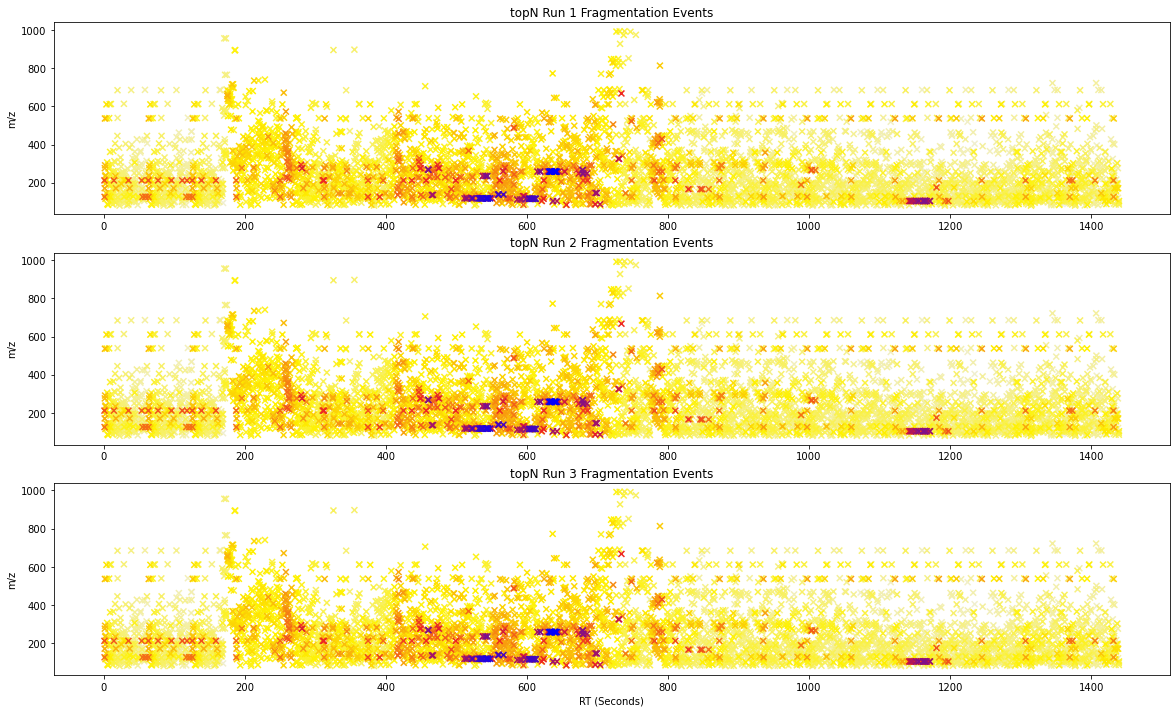

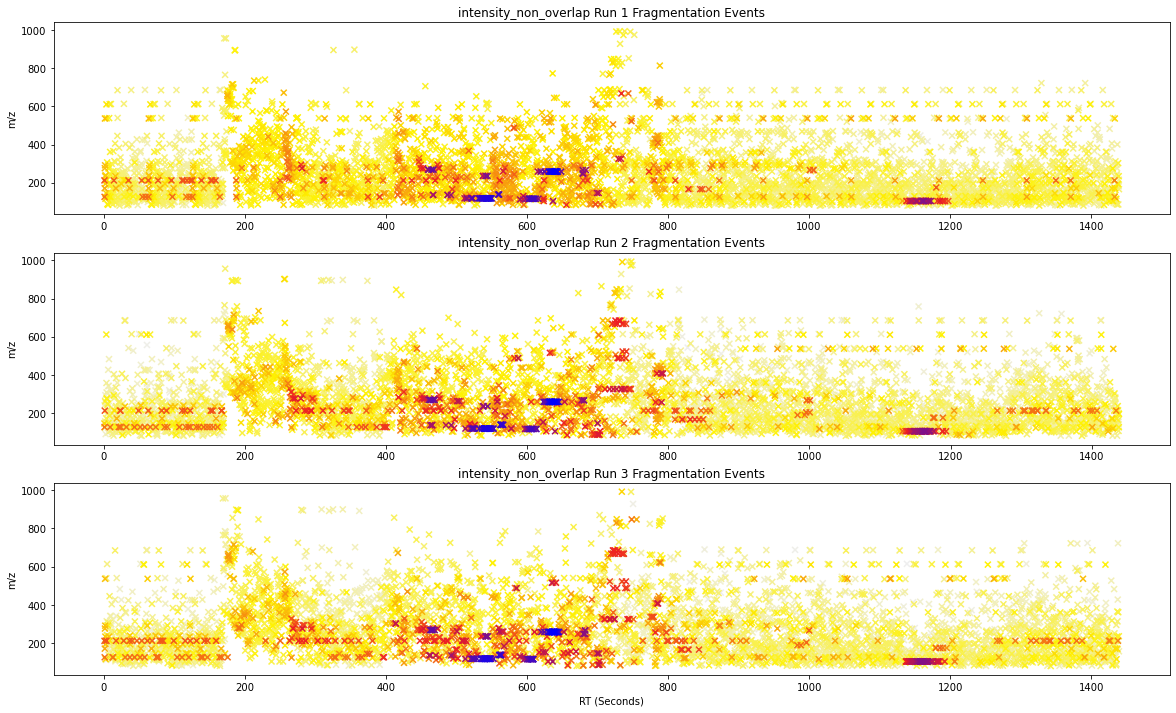

In [10]:
# Plot fragmentation events

import os
import math

from vimms.BoxVisualise import mpl_fragmentation_events

for case_name in ["topN", "intensity_non_overlap"]:
    mzmls = [os.path.join(out_dir, f"beer_{case_name}_{i}.mzML") for i in range(len(beer_chem_list))]
    fig, ax = mpl_fragmentation_events(case_name, mzmls, colour_minm=math.log(500.0)) # colour_minm controls the minimum the colourscale will start interpolating values between, to make things look nicer

Each cross marks the centre of an isolation window, and is coloured based on the precursor intensity from grey to yellow to red to blue as intensity increases. From this we can see that TopN is indeed putting fragmentation events in the same place with each run, but Intensity Non-Overlap's choices are different.

## Evaluation

Now we've run our fragmentation strategies, we want to compare them. The most obvious way to measure a fragmentation strategy's performance in terms of metabolite coverage. That is, how many fragmentation spectra can we collect in the sample that we can identify as belonging to a known metabolite? A semi-automated way to do this is to evaluate each fragmentation spectrum collected against a database of reference spectra by e.g. the cosine score. This approach uses a natural performance metric, but also has its limitations. This relies on the presence of a database containing the metabolites in the sample and with a sufficiently low false-positive rate - which could be problematic given we are testing our ability to collect things we wouldn't ordinarily collect, and our end-goal is to characterise unknown samples! Additionally, how metabolites are distributed among peaks in the sample might be unusual compared to other sample types, and this might affect the generalisability of our conclusions.

An alternative more closely tied to the algorithmic behaviour of fragmentation strategies is to measure **peak coverage** (which we may refer to as just coverage). Given some ground-truth set of chromatographic peaks, a fragmentation strategy gets a point for each peak that is included in the isolation window of any MS2 scan at a precursor intensity above some minimum intensity threshold. The sum of these points is the fragmentation strategy's peak coverage score. To measure the quality at which we acquired peaks, we use **intensity coverage**. Instead of awarding a binary {0, 1} score to each peak, we give it a score in the interval \[0, 1\] - this score is the ratio of the highest precursor intensity the peak was fragmented at over the highest precursor intensity appearing in that peak. That is, we rate each peak by how much of the total intensity we actually fragmented it at as a proportion of the maximum intensity that we saw it was possible to fragment it at. When computing cumulative coverage across multiple injections, if we can identify that the same peak appears in both, then we only count it once for coverage. For cumulative intensity coverage, the numerator is the highest precursor intensity any peak was fragmented at in any injection, and the denominator is the highest intensity observed in it in any injection. These metrics are easier to deploy, but they can also be used to complement metabolite coverage for a more complete picture of fragmentation strategy performance.

In synthetic data, we know all the chemicals we generated, so checking if they were within an MS2 scan's isolation window is straightforward: we just use the `SyntheticEvaluator` object which can be invoked on a list of `Environment` objects by the constructor `from_envs`. We can then call `summarise` on it to see a report of the results.

In [11]:
# Evaluate synthetic data
# NB: For synthetic chems "Number of chems above min intensity" just reads the max intensity value stored
# in the Chemical object, not its maximum intensity during a fragmentation run

from vimms.Evaluation import SyntheticEvaluator

print("topN")
topN_results = SyntheticEvaluator.from_envs(topN_envs)
print(topN_results.summarise(
        min_intensity = 5000.0 # Don't count any peaks that don't contain a point above this threshold in the fragmentation run...
))

print("\n")

print("Intensity Non-Overlap")
ino_results = SyntheticEvaluator.from_envs(ino_envs)
print(ino_results.summarise(
        min_intensity = 5000.0 # Don't count any peaks that don't contain a point above this threshold in the fragmentation run...
))

topN
Number of chems above min intensity: 5000
Number of fragmentations: [4324, 4324, 4324]
Cumulative coverage: [2932, 2932, 2932]
Cumulative coverage proportion: [0.5864, 0.5864, 0.5864]
Cumulative intensity proportion: [0.33861659108895686, 0.33861659108895686, 0.33861659108895686]
Cumulative intensity proportion of covered spectra: [0.5774498483781666, 0.5774498483781666, 0.5774498483781666]
Times covered: {0: 2068, 3: 2932}
Times fragmented: {0: 1938, 3: 2043, 6: 801, 9: 195, 12: 21, 15: 2}


Intensity Non-Overlap
Number of chems above min intensity: 5000
Number of fragmentations: [4325, 4354, 4310]
Cumulative coverage: [2922, 3432, 3698]
Cumulative coverage proportion: [0.5844, 0.6864, 0.7396]
Cumulative intensity proportion: [0.3378124365078834, 0.48143038216412753, 0.5432870939912067]
Cumulative intensity proportion of covered spectra: [0.578050028247576, 0.7013845893999526, 0.7345688128599334]
Times covered: {0: 1302, 1: 983, 2: 377, 3: 2338}
Times fragmented: {0: 1138, 1: 959

When working with real data (e.g. in both re-simulated and lab experiments) the situation is more complicated. We do not necessarily know which chromatographic peaks correspond to real metabolites, and we need to produce a list of ground-truth peaks to evaluate against. Fortunately there are a number of algorithms that aim to pick peaks from a sample, and implementations can be found large mass spectrometry data packages. Both XCMS and MZMine implement the `centwave` algorithm, and MZMine additionally implements the more recent ADAP algorithm. We can run these algorithms through ViMMS by using objects like `XCMSScriptParams` or `MZMineParams` which instantiate a subprocess through Python's `subprocess`. Then to the set of output peaks we can use a `RealEvaluator` object to assign fragmentation intensities, maximum observed intensities, etc. For convenience we'll use the function `evaluate_real` to create a `RealEvaluator` and perform several steps on it for us, and call `summarise` on it to see a report of the results. (Note that you can evaluate .mzMLs written in synthetic experiments in the same way.)

In [12]:
# Create a peak-picked file to evaluate with

import os
from vimms.PeakPicking import XCMSScriptParams

pp_params = XCMSScriptParams( # Pick peaks with a small R script running XCMS - this object knows how to run the script and read and write files with it...
    xcms_r_script = os.path.join(user_vimms, "vimms", "scripts", "xcms_script.R"), # Where our runner script lives...
    # See XCMS documentation for details on parameters
    ppm = 15,
    pwlower = 15,
    pwupper = 80,
    snthresh = 5,
    noise = 1000,
    prefilterlower = 3,
    prefilterupper = 500
)

aligned_file = pp_params.pick_aligned_peaks( 
    input_files = [beer_fullscan], # Peak-picking works better with richer MS1 info, i.e. ideally on a fullscan...
    output_dir = out_dir,
    output_name = "beer_peak_picked.csv",
    force = False # If the file exists, don't run this again...
)

print(f"Peak-picked file written to: {aligned_file}") # Just a filepath

Running XCMS for tests\results\beer_peak_picked_xcms_aligned.csv
12360 aligned boxes contained in file
Peak-picked file written to: tests\results\beer_peak_picked_xcms_aligned.csv


In [13]:
# Let the Evaluator know how the files are linked

mzml_map = { # For each experiment case, pairs of fragmentation run file and fullscan to evaluate it with
    "topN" : [
        (beer_fullscan, os.path.join(out_dir, f"beer_topN_{i}.mzML"))
        for i, _ in enumerate(beer_chem_list)
    ],
    
    "intensity_non_overlap" : [
        (beer_fullscan, os.path.join(out_dir, f"beer_intensity_non_overlap_{i}.mzML"))
        for i, _ in enumerate(beer_chem_list)
    ]
}

In [14]:
# Evaluate the re-simulated experiment!

from vimms.Evaluation import evaluate_real

exp_names = ["topN", "intensity_non_overlap"]
exp_results = [] # Store Evaluator objects here

for exp_name in exp_names:
    mzml_pairs = mzml_map[exp_name]
    
    eva = evaluate_real(
        aligned_file, # Peak-picked file we just made
        mzml_pairs, # Which files to evaluate
        isolation_width = 1.0, # How wide the window should be for things we want to consider fragmented
        pp_reader = pp_params # Object that knows how to read aligned_file
    )
    
    print(exp_name)
    print(eva.summarise(
        min_intensity = 5000.0 # Don't count any peaks that don't contain a point above this threshold in the fragmentation run...
    ))
    exp_results.append(eva)

2023-10-03 17:53:43.928 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 17:53:51.399 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 17:54:01.964 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans


topN


2023-10-03 17:54:12.561 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 17:54:14.694 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 17:54:16.829 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans


Number of chems above min intensity: 11761
Number of fragmentations: [5677, 5677, 5677]
Cumulative coverage: [3912, 3912, 3912]
Cumulative coverage proportion: [0.3326247768046935, 0.3326247768046935, 0.3326247768046935]
Cumulative intensity proportion: [0.22846141283862503, 0.22846141283862503, 0.22846141283862503]
Cumulative intensity proportion of covered spectra: [0.6868442424322774, 0.6868442424322774, 0.6868442424322774]
Times covered: {0: 8448, 3: 3912}
Times fragmented: {0: 7875, 3: 3251, 6: 821, 9: 224, 12: 61, 15: 24, 18: 7, 21: 2, 24: 2, 27: 4, 33: 32, 36: 1, 39: 8, 42: 5, 45: 1, 48: 8, 60: 2, 63: 12, 69: 14, 72: 3, 75: 2, 84: 1}


2023-10-03 17:54:19.243 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6262 scans
2023-10-03 17:54:29.979 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6249 scans
2023-10-03 17:54:40.753 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6225 scans


intensity_non_overlap


2023-10-03 17:54:51.546 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6262 scans
2023-10-03 17:54:53.669 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6249 scans
2023-10-03 17:54:55.822 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6225 scans


Number of chems above min intensity: 11979
Number of fragmentations: [5684, 5652, 5622]
Cumulative coverage: [3865, 5820, 7099]
Cumulative coverage proportion: [0.3226479672760664, 0.4858502379163536, 0.5926204190667]
Cumulative intensity proportion: [0.2066383156296255, 0.35297701117957114, 0.45882637742927884]
Cumulative intensity proportion of covered spectra: [0.6404451184805392, 0.7265140235257874, 0.7742331561100622]
Times covered: {0: 5261, 1: 3842, 2: 2017, 3: 1240}
Times fragmented: {0: 4506, 1: 3581, 2: 1857, 3: 1120, 4: 476, 5: 252, 6: 173, 7: 81, 8: 53, 9: 32, 10: 27, 11: 10, 12: 25, 13: 15, 14: 31, 15: 6, 16: 2, 17: 5, 18: 8, 19: 2, 20: 1, 24: 2, 26: 1, 29: 2, 30: 1, 33: 4, 34: 1, 36: 26, 42: 1, 55: 1, 56: 1, 58: 1, 60: 1, 61: 2, 62: 2, 63: 2, 64: 3, 65: 1, 66: 1, 67: 1, 70: 3, 71: 3, 73: 2, 79: 1, 84: 1, 86: 1, 87: 12, 118: 1, 119: 1, 123: 1, 124: 1, 125: 4, 126: 2, 129: 2, 130: 1, 131: 3, 132: 1, 134: 1, 135: 1, 141: 1}


We can see that TopN performs exactly the same number of fragmentations each time, and never gains in coverage: this is because it is performing exactly the same actions when it sees exactly the same sample (though lab experiments have some inherent stochasticity which helps it somewhat). By contrast Intensity Non-Overlap tries to exclude peaks it has hit in previous samples, so will try to increase both coverage and intensity coverage even with repeated injections of the same sample.

There are also convenience plotting methods to plot comparisons between `Evaluator` objects:

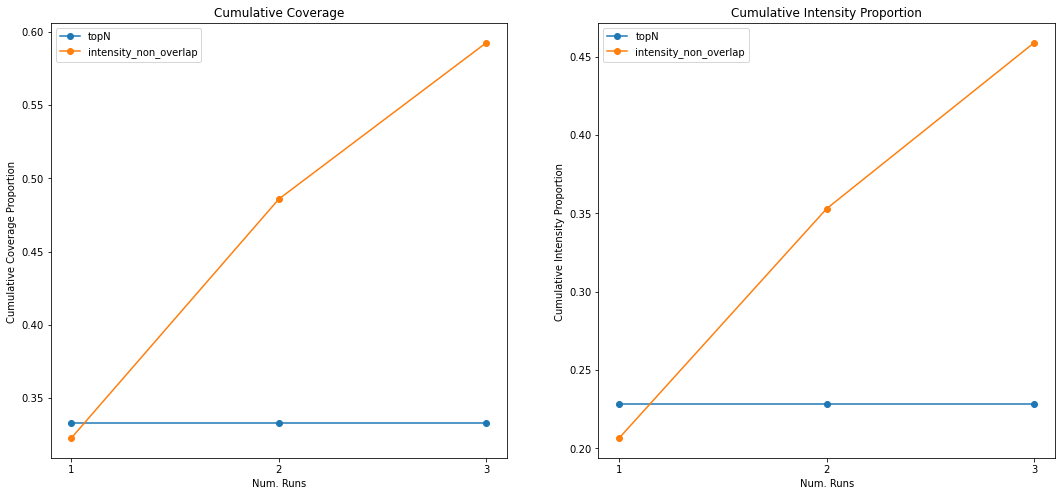

In [15]:
# Plot the results

from vimms.BoxVisualise import mpl_results_plot, mpl_set_figure_style

fig, axes = mpl_results_plot( # Plot cumulative coverage and cumulative intensity coverage
    exp_names,
    exp_results,
    markers = ["o" for _ in exp_names],
    min_intensity = 5000.0, # As above
    # This plot can be styled in many ways...
)

mpl_set_figure_style(
    fig,
    figure_sizes = (18, 8),
)

for ax in axes:
    ax.set_xticks([x for x in range(1, len(beer_chem_list) + 1)])

## Experiment Interface

To try and make common use cases a bit shorter to write, ViMMS also offers an alternative interface through Experiment.py. For example, it automates streaming `Chemical` objects to and from disc to save memory, and multiprocesses each case of the experiment. Now let's redo the previous experiment using it. (At the time of writing Experiment.py only supports re-simulated experiments.)

The basic structure is similar to before, but we load `ExperimentCase` objects representing a separate series of runs we want to compare (in our case topN and Intensity Non-Overlap) into an `Experiment` object and call methods on it.

In [16]:
# Parameters for controllers which will be passed using Python's **
# We could've done this for brevity up above too, but for simplicity's sake we didn't...

from vimms.Common import POSITIVE
from vimms.Roi import RoiBuilderParams

topN_params = {
    "ionisation_mode" : POSITIVE,
    "N" : 10,
    "isolation_width" : 1.0,
    "min_ms1_intensity" : 5000,
    "mz_tol" : 10,
    "rt_tol" : 60
}

intensity_non_overlap_params = {
    **topN_params, # Copy the topN parameters
    "min_roi_length_for_fragmentation" : 0,
    "roi_params" : RoiBuilderParams(
                        min_roi_intensity=0,
                        min_roi_length=3,
                   )
}

In [17]:
# Actually run the experiment

from vimms.Box import BoxGrid
from vimms.BoxManager import BoxSplitter, BoxManager
from vimms.Experiment import ExperimentCase, Experiment

beer_fullscans = [beer_fullscan] * 3
exp_out_dir = os.path.join("tests", "results", "experiment")
min_rt, max_rt = 0, 1440 # Interval to be simulated
scan_duration_dict = {1: 0.59, 2: 0.19} # For reproducibility, fix each scan's length to average lengths on our instrument

geom = BoxManager( # Need a separate BoxManager for every class that uses one... But ExperimentCases will copy it at initialisation so your original state object won't be affected
    box_geometry = BoxGrid(),
    box_splitter = BoxSplitter(split=True)
)

same_beer_exp = Experiment()
same_beer_exp.add_cases([
        ExperimentCase(
            "topN", # Experiment.py has a list of known controller names it can look up
            beer_fullscans, # Fullscans to generate chemicals from
            topN_params, # "Normal" parameters to give to controller i.e. stuff where we don't care about shared state
            name = "topN", # What you want to call this case - by default the controller name
            pickle_env = False # When enabled this will save some of the Python objects generated during the run in case you want to inspect them
        ),
    
        ExperimentCase(
            "intensity_non_overlap",
            beer_fullscans,
            intensity_non_overlap_params,
            name = "intensity_non_overlap",
            grid_base = geom, # Shared state so needs to be passed separately
            pickle_env = False
        )
])

same_beer_exp.run_experiment(
    exp_out_dir,
    min_rt = min_rt,
    max_rt = max_rt,
    ionisation_mode = POSITIVE,
    scan_duration_dict = scan_duration_dict,
    point_noise_threshold = 0, # Any points below this threshold will not be re-simulated
    chem_noise_threshold = 0, # Any chemical RoIs without a point above this threshold will not be re-simulated
    num_workers = 2 # Allowed to spawn n processes for multiprocessing
)

Creating Chemicals...

Running Experiment of 2 cases...


In [18]:
# Now evaluate

isolation_width = 1.0

pp_params = XCMSScriptParams( # Pick peaks with a small R script running XCMS - this object knows how to run the script and read and write files with it...
    xcms_r_script = os.path.join(user_vimms, "vimms", "scripts", "xcms_script.R"), # Where our runner script lives...
    # See XCMS documentation for details on parameters
    ppm = 15,
    pwlower = 15,
    pwupper = 80,
    snthresh = 5,
    noise = 1000,
    prefilterlower = 3,
    prefilterupper = 500
)

same_beer_exp.evaluate(
    pp_params = pp_params,
    num_workers = 2,
    isolation_widths = isolation_width,
    aligned_names = "beer_peak_picked.csv", # Name of peak-picked file
    force_peak_picking = False, # If True, run peak-picking even when file already exists
    check_files = "exact" # Make sure the fullscan names match the ones in the peak-picked file
)

same_beer_exp.summarise(
    num_workers = 2,
    min_intensities = 5000.0,
    rank_key = "cumulative_intensity_proportion" # Which score to order by best to worst performing
)

Running XCMS for tests\results\experiment\beer_peak_picked_xcms_aligned.csv
12360 aligned boxes contained in file
12360 aligned boxes contained in file

intensity_non_overlap
Number of chems above min intensity: 11979
Number of fragmentations: [5684, 5652, 5622]
Cumulative coverage: [3865, 5820, 7099]
Cumulative coverage proportion: [0.3226479672760664, 0.4858502379163536, 0.5926204190667]
Cumulative intensity proportion: [0.2066383156296255, 0.35297701117957114, 0.45882637742927884]
Cumulative intensity proportion of covered spectra: [0.6404451184805392, 0.7265140235257874, 0.7742331561100622]
Times covered: {0: 5261, 1: 3842, 2: 2017, 3: 1240}
Times fragmented: {0: 4506, 1: 3581, 2: 1857, 3: 1120, 4: 476, 5: 252, 6: 173, 7: 81, 8: 53, 9: 32, 10: 27, 11: 10, 12: 25, 13: 15, 14: 31, 15: 6, 16: 2, 17: 5, 18: 8, 19: 2, 20: 1, 24: 2, 26: 1, 29: 2, 30: 1, 33: 4, 34: 1, 36: 26, 42: 1, 55: 1, 56: 1, 58: 1, 60: 1, 61: 2, 62: 2, 63: 2, 64: 3, 65: 1, 66: 1, 67: 1, 70: 3, 71: 3, 73: 2, 79: 1, 84

2023-10-03 18:05:50.175 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 18:05:55.916 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 18:05:58.081 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 18:06:00.255 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6262 scans
2023-10-03 18:06:02.417 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6249 scans
2023-10-03 18:06:04.573 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6225 scans


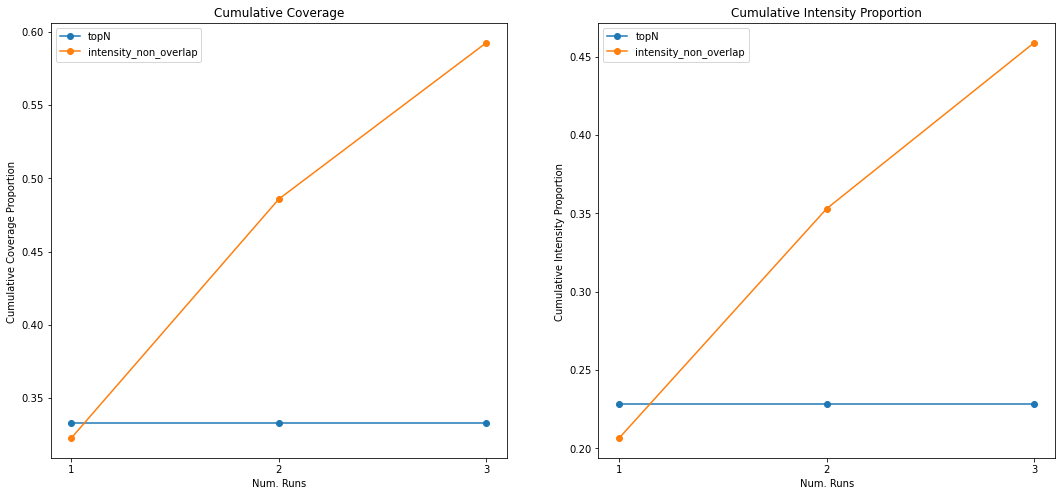

In [19]:
# And plot again

from vimms.BoxVisualise import mpl_results_plot, mpl_set_figure_style

fig, axes = mpl_results_plot( # Plot cumulative coverage and cumulative intensity coverage
    exp_names,
    same_beer_exp.evaluators,
    markers = ["o" for _ in exp_names],
    min_intensity = 5000.0, # As above
    # This plot can be styled in many ways...
)

mpl_set_figure_style(
    fig,
    figure_sizes = (18, 8),
)

for ax in axes:
    ax.set_xticks([x for x in range(1, len(beer_chem_list) + 1)])

Re-simulating experiments with lots of complex .mzMLs can take a lot of time, so we commonly split the generation and evaluation into separate notebooks or re-run only some of the cases. It's therefore possible to instantiate an Experiment object with the data needed for evaluation from the .mzMLs. It's possible to do this by manually specifying the .mzMLs to load from, but when running an `Experiment` it also includes a small "keyfile" describing which .mzMLs are linked to which cases and which can be parsed to re-load and evaluate a previously run `Experiment`.

In [20]:
# Load the Experiment from the keyfile and .mzMLs

from vimms.Experiment import ExperimentCase, Experiment

same_beer_exp = Experiment.load_from_json(
    file_dir = exp_out_dir, # Where the keyfile is
    file_name = "keyfile.json", # What the keyfile is called
    out_dir = exp_out_dir, # Directory associated with the Experiment
    fullscan_dir = os.path.dirname(beer_fullscan), # Parent directory of seed files
    amend_result_path = True, # If true, overwrite directory path of .mzMLs written in the file with out_dir
    case_names = ["topN", "intensity_non_overlap"]
)

In [21]:
# Same evaluation... Should get the same result!

same_beer_exp.evaluate(
    pp_params = pp_params,
    num_workers = 2,
    isolation_widths = isolation_width,
    aligned_names = "beer_peak_picked.csv", # Name of peak-picked file
    force_peak_picking = False, # If True, run peak-picking even when file already exists
    check_files = "exact" # Make sure the fullscan names match the ones in the peak-picked file
)

same_beer_exp.summarise(
    num_workers = 2,
    min_intensities = 5000.0,
    rank_key = "cumulative_intensity_proportion", # Which score to order by best to worst performing
)

12360 aligned boxes contained in file
12360 aligned boxes contained in file

intensity_non_overlap
Number of chems above min intensity: 11979
Number of fragmentations: [5684, 5652, 5622]
Cumulative coverage: [3865, 5820, 7099]
Cumulative coverage proportion: [0.3226479672760664, 0.4858502379163536, 0.5926204190667]
Cumulative intensity proportion: [0.2066383156296255, 0.35297701117957114, 0.45882637742927884]
Cumulative intensity proportion of covered spectra: [0.6404451184805392, 0.7265140235257874, 0.7742331561100622]
Times covered: {0: 5261, 1: 3842, 2: 2017, 3: 1240}
Times fragmented: {0: 4506, 1: 3581, 2: 1857, 3: 1120, 4: 476, 5: 252, 6: 173, 7: 81, 8: 53, 9: 32, 10: 27, 11: 10, 12: 25, 13: 15, 14: 31, 15: 6, 16: 2, 17: 5, 18: 8, 19: 2, 20: 1, 24: 2, 26: 1, 29: 2, 30: 1, 33: 4, 34: 1, 36: 26, 42: 1, 55: 1, 56: 1, 58: 1, 60: 1, 61: 2, 62: 2, 63: 2, 64: 3, 65: 1, 66: 1, 67: 1, 70: 3, 71: 3, 73: 2, 79: 1, 84: 1, 86: 1, 87: 12, 118: 1, 119: 1, 123: 1, 124: 1, 125: 4, 126: 2, 129: 2, 

2023-10-03 18:07:16.755 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 18:07:18.956 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 18:07:21.174 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6256 scans
2023-10-03 18:07:23.391 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6262 scans
2023-10-03 18:07:25.612 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6249 scans
2023-10-03 18:07:27.819 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 6225 scans


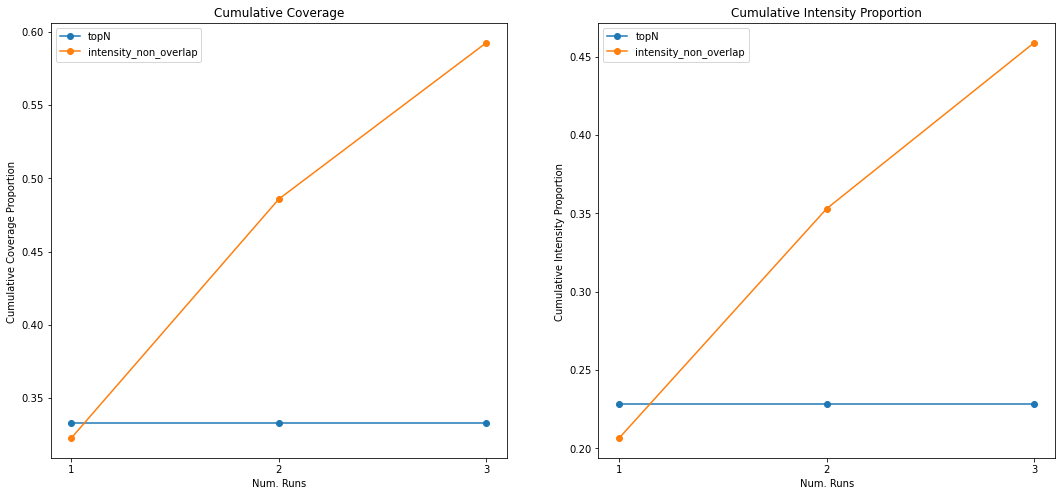

In [22]:
# Plot again... Should be same!

from vimms.BoxVisualise import mpl_results_plot, mpl_set_figure_style

fig, axes = mpl_results_plot( # Plot cumulative coverage and cumulative intensity coverage
    exp_names,
    same_beer_exp.evaluators,
    markers = ["o" for _ in exp_names],
    min_intensity = 5000.0, # As above
    # This plot can be styled in many ways...
)

mpl_set_figure_style(
    fig,
    figure_sizes = (18, 8),
)

for ax in axes:
    ax.set_xticks([x for x in range(1, len(beer_chem_list) + 1)])

These are relatively small examples, but more involved examples can be found in the notebooks we have used for our research publications - at the time of writing these can be found [in the ViMMS Github repository](https://github.com/glasgowcompbio/vimms/tree/master) in the Examples folder.

## Controlling a Real Instrument

In order to control a real instrument ViMMS requires bridging code which communicates between the pure-Python codebase of ViMMS and the API of said instrument. Said bridging code "translates" the high-level Python code to the specific language of the instrument, and each piece of bridging code can naturally only be used with instruments that expose such a compatible API. At the time of writing, bridging code has been written that is compatible with Thermo Orbitrap Fusion instruments, but licensing restrictions mean it cannot be shared publicly. Please contact us if you're interested in running something on a real machine.